In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [2]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.stats.api as sms
import ssm
from ssm.util import find_permutation
from sklearn import preprocessing

from src.utils import pmf_utils, plot_utils, glm_hmm_utils


import numpy.random as npr
npr.seed(0)

### Load Config

In [4]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)


### Utils functions

In [ ]:
def extract_previous_trial_data(trial_data):
    target = np.array(trial_data['target'])
    prev_target = np.hstack([target[0] , target[:-1]])  # -1:awayRF, 1:toRF of previous valid trial
    choice = np.array(trial_data.choice > 0)
    prev_choice = np.hstack([choice[0], choice[:-1]])
    outcome = np.array(trial_data.outcome.astype(int))
    prev_outcome = np.hstack([outcome[0], outcome[:-1]])

    prev_valid_idx = np.where(prev_outcome >= 0)[0]
    prev_invalid_idx = [] #np.where(prev_outcome == -1)[0]

    for i in prev_invalid_idx:
        if i < prev_valid_idx[0]: #randomly sample if no previous valid trials
            prev_choice[i] = np.random.binomial(1,0.5)
            prev_target[i] = np.random.binomial(1,0.5) * 2 - 1
        else:
            last_valid =  np.where(prev_valid_idx<i)[0][-1]
            prev_choice[i] = prev_choice[prev_valid_idx[last_valid]]
            prev_target[i] = prev_target[prev_valid_idx[last_valid]]

    prev_choice = (prev_choice * 2) - 1 # -1:awayRF, 1:toRF of previous valid trial
    return prev_choice.astype(int), prev_target.astype(int)

def prepare_input_data(data, input_dim):
    X = np.ones((1, data.shape[0], input_dim))

    current_stimulus = data.signed_coherence
    current_stimulus = current_stimulus / 100
    X[0,:,0] = current_stimulus
    X[0, :, 1] = data.color
    X[0,:,3], X[0,:,4] = extract_previous_trial_data(data)
    return list(X)

# def process_session_data(data):
#     data['target'] = (2*data.target - 1).astype(int)
#     data['choice'] = data['choice'].astype(int)
#     data['signed_coherence'] = data['coherence'] * data['target']
#     data['previous_target'] = data.target.shift(1)
#     data.loc[data.index[0], 'previous_target'] = data.target.values[0]
#     data['previous_choice'] = data.choice.shift(1)
#     data.loc[data.index[0], 'previous_choice'] = data.choice.values[0]

#     first_valid = np.where(data.outcome >= 0)[0][0]
#     indices_to_change_previous_choice = data[data.previous_choice == -1].index

#     for i in indices_to_change_previous_choice:
#         if i < first_valid:
#             data.loc[data.index[i], 'previous_choice'] = np.random.choice([-1, 1])
#             data.loc[data.index[i], 'previous_target'] = np.random.choice([-1, 1])
#         else:
#             j=0
#             while i - j >= 0 and data.at[data.index[i - j], 'previous_choice'] == -1:
#                 j+=1
#             data.loc[data.index[i], 'previous_choice'] = data.loc[data.index[i-j], 'previous_choice']
#             data.loc[data.index[i], 'previous_target'] = data.loc[data.index[i-j], 'previous_target']


#     data['previous_choice'].replace(0, -1, inplace=True) # remap previous choice to -1, 1

#     return data


def plot_model_fit(model, num_states, input_dim):

    fix, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.ravel()
    plt.subplots_adjust(hspace=0.5)  # Increase space between horizontal rows

    cols = ['#ff7f00', '#4daf4a', '#377eb8']
    recovered_weights = -model.observations.params
    for k in range(num_states):
        if k ==0:
            axs[1].plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = "recovered", linestyle = '--')
        else:
            axs[1].plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = '', linestyle = '--')
    axs[1].set_ylabel("GLM weight", fontsize=15)
    axs[1].set_xlabel("covariate", fontsize=15)
    axs[1].set_xticks([0, 1, 2, 3], ['stimulus', 'previous_choice,', 'previous_stimulus', 'bias'], fontsize=12, rotation=10)
    axs[1].axhline(y=0, color="k", alpha=0.5, ls="--")
    axs[1].legend(fontsize=12);
    axs[1].set_title("Weight recovery", fontsize=15)

    recovered_trans_mat = np.exp(model.transitions.log_Ps)
    axs[2].imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
    for i in range(recovered_trans_mat.shape[0]):
        for j in range(recovered_trans_mat.shape[1]):
            text = axs[2].text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                            color="k", fontsize=12)
    axs[2].set_xlim(-0.5, num_states - 0.5)
    axs[2].set_xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
    axs[2].set_yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
    axs[2].set_ylim(num_states - 0.5, -0.5)
    axs[2].set_title("Transition Probability", fontsize = 20)


    posterior_probs = [model.expected_states(data=data, input=input)[0]
                    for data, input
                    in zip(choices, inputs)]

    sess_id = 0 #session id; can choose any index between 0 and num_sess-1
    for k in range(num_states):
        axs[3].plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
                color=cols[k])
    axs[3].set_ylim((-0.01, 1.01))
    axs[3].set_yticks([0, 0.5, 1], [0, 0.5, 1], fontsize = 10)
    axs[3].set_xlabel("trial #", fontsize = 15)
    axs[3].set_ylabel("p(state)", fontsize = 15)
    axs[3].set_title("State Transition", fontsize = 20)

### Import Data

In [5]:
data = pd.read_csv(Path(processed_dir, "processed_data60accu_allowed.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_60accu_allowed.csv"), index_col=None)

#### Pre-process data

In [ ]:
# exclude the following subjects where categorization score is more than 3
reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 3]['subject_id']
processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]

# Getting indices of on and off treatment from same subject in processed metadata
subject_treatment_idx = pd.DataFrame(columns=['subject', 'off', 'on'])
subtype_idx = pd.DataFrame(columns=['subject', 'off', 'on'])

for idx, sub in enumerate(processed_metadata['subject_id'].unique()):
    sub_df = processed_metadata.loc[processed_metadata['subject_id'] == sub]
    subject_treatment_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

    # print(f"Subject {sub} has {sub_df['categorization_score'].values} categorization_score")
    if np.sum(np.isnan(sub_df['categorization_score'])) == 0:
        # put off treatment first column and on treatment second column one row at a time
        subtype_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]


data["filename"] = None
for idx, subject in enumerate(subtype_idx.subject):
    off_filename = processed_metadata.file_name[subtype_idx.off[idx]]
    on_filename = processed_metadata.file_name[subtype_idx.on[idx]]

    data.loc[(data['subject'] == subject) & (data['medication'] == 'off'), 'filename'] = off_filename
    data.loc[(data['subject'] == subject) & (data['medication'] == 'on'), 'filename'] = on_filename

sessions = processed_metadata.file_name[list(subtype_idx.off) + list(subtype_idx.on)].reset_index(drop=True)

### Model Preparation

In [7]:
_obs_dim = 1             # number of observed dimensions
_num_categories = 2      # number of categories for output
_input_dim = 5           # input dimensions

### Data Preparation

In [ ]:
inputs_session_wise = []
choices_session_wise = []
invalid_idx_session_wise = []
masks_session_wise = []

for session_id in sessions:
    trial_data = data[data.filename == session_id].reset_index(drop=True)

    inputs_session_wise += prepare_input_data(trial_data, _input_dim)
    choices = np.array(trial_data.choice >= 0).reshape(-1,1).astype('int')

    # masks_session_wise.append(np.array(choices >= 0))
    masks_session_wise.append(np.ones(choices.shape, dtype=int))
    invalid_idx = np.array([]) #np.where(choices == -1)[0].reshape(-1,1)
    invalid_idx_session_wise.append(invalid_idx)

    # for training, replace -1 with random sample from 0,1
    choices[choices == -1] = npr.choice(1,invalid_idx.shape[0])

    choices_session_wise.append(choices)

inputs_aggregated, choices_aggregated, masks_aggregated = [], [], []
inputs_aggregated.append(np.vstack(inputs_session_wise))
choices_aggregated.append(np.vstack(choices_session_wise))
masks_aggregated.append(np.vstack(masks_session_wise))

# scaling signed coherence
inputs_aggregated[0][:,0] = preprocessing.scale(inputs_aggregated[0][:, 0], axis=0)
for idx_session in range(len(sessions)):
    inputs_session_wise[idx_session][:,0] = preprocessing.scale(inputs_session_wise[idx_session][:, 0], axis=0)

In [127]:
models_glm_hmm, fit_lls_glm_hmm = glm_hmm_utils.global_fit(observations=choices_aggregated, inputs=inputs_aggregated, masks=masks_aggregated, n_iters=2000, n_initializations=20)

Fitting GLM globally...


  0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 2 states...


Converged to LP: -8785.0:  10%|▉         | 197/2000 [00:12<01:58, 15.26it/s]


Fitting 3 states...


LP: -9199.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -9295.2:   0%|          | 1/2000 [00:00<04:34,  7.27it/s]

Fitting 5 states...


LP: -8649.0: 100%|██████████| 2000/2000 [02:30<00:00, 13.26it/s]


In [128]:
global_fits = {
    'models': models_glm_hmm,
    'fits_lls_glm_hmm': fit_lls_glm_hmm,
}

with open(Path(processed_dir, 'models_glm_hmm_global.pkl'), 'wb') as f:
    pickle.dump(global_fits, f)

In [132]:
# get best model of 20 initializations for each state
init_params = {
    'glm_weights': {},
    'transition_matrices': {}
}
for n_states in np.arange(2,6):
    best_idx = np.argmax([np.max(arr) for arr in fit_lls_glm_hmm[n_states]])
    init_params['glm_weights'][n_states] = models_glm_hmm[n_states][best_idx].observations.params
    init_params['transition_matrices'][n_states] = models_glm_hmm[n_states][best_idx].transitions.params

In [133]:
# fit session-wise with 5 fold cross-validation
models_session_state_fold, session_train_ll, session_test_ll = glm_hmm_utils.session_wise_fit_cv(observations=choices_session_wise, inputs=inputs_session_wise, masks=masks_session_wise,
                                                                    n_sessions=len(sessions), init_params=init_params, n_iters=2000)

Fitting session 0...
Fitting 2 states...


Converged to LP: -300.0:   1%|          | 24/2000 [00:00<00:09, 218.77it/s]


Fitting 3 states...


Converged to LP: -320.7:   5%|▍         | 94/2000 [00:00<00:09, 193.26it/s]


Fitting 4 states...


Converged to LP: -361.7:   4%|▍         | 75/2000 [00:00<00:13, 145.47it/s]


Fitting 5 states...


Converged to LP: -385.7:   5%|▌         | 104/2000 [00:00<00:12, 150.55it/s]


Fitting session 1...
Fitting 2 states...


Converged to LP: -318.4:   1%|          | 24/2000 [00:00<00:14, 140.69it/s]


Fitting 3 states...


LP: -381.6:   1%|          | 14/2000 [00:00<00:14, 138.94it/s]

Fitting 4 states...


LP: -420.1:   1%|          | 14/2000 [00:00<00:15, 131.66it/s]

Fitting 5 states...


LP: -251.7:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 2...
Fitting 2 states...


LP: -286.4:   1%|          | 19/2000 [00:00<00:10, 183.13it/s]

Fitting 3 states...


LP: -319.6:   1%|          | 14/2000 [00:00<00:14, 137.78it/s]

Fitting 4 states...


LP: -356.6:   1%|          | 13/2000 [00:00<00:16, 123.30it/s]

Fitting 5 states...


LP: -365.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 3...
Fitting 2 states...
Fitting 3 states...


LP: -459.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -463.2:   1%|          | 15/2000 [00:00<00:13, 148.41it/s]

Fitting 5 states...


LP: -322.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 4...
Fitting 2 states...
Fitting 3 states...
Fitting 4 states...


LP: -398.0:   1%|          | 11/2000 [00:00<00:19, 104.21it/s]

Fitting 5 states...


LP: -252.4:   1%|▏         | 28/2000 [00:00<00:07, 276.57it/s]

Fitting session 5...
Fitting 2 states...


LP: -300.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -329.2:   0%|          | 9/2000 [00:00<00:22, 88.55it/s]s]

Fitting 4 states...


LP: -389.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -345.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 6...
Fitting 2 states...
Fitting 3 states...


LP: -419.9:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -452.9:   1%|          | 12/2000 [00:00<00:17, 112.68it/s]

Fitting 5 states...


LP: -358.0:   1%|          | 19/2000 [00:00<00:10, 185.60it/s]

Fitting session 7...
Fitting 2 states...
Fitting 3 states...


LP: -396.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -444.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -331.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 8...
Fitting 2 states...


LP: -356.7:   1%|          | 23/2000 [00:00<00:08, 224.10it/s]

Fitting 3 states...


LP: -399.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -452.7:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


Converged to LP: -435.0:   6%|▌         | 113/2000 [00:00<00:13, 138.94it/s]


Fitting session 9...
Fitting 2 states...


LP: -374.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -406.5:   0%|          | 10/2000 [00:00<00:20, 97.84it/s]]

Fitting 4 states...


LP: -445.3:   1%|          | 16/2000 [00:00<00:12, 159.17it/s]

Fitting 5 states...


Converged to LP: -304.0:   0%|          | 9/2000 [00:00<00:11, 170.68it/s]


Fitting session 10...
Fitting 2 states...
Fitting 3 states...


LP: -374.7:   1%|          | 11/2000 [00:00<00:18, 107.21it/s]

Fitting 4 states...


LP: -419.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -325.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 11...
Fitting 2 states...


LP: -373.5:   1%|          | 12/2000 [00:00<00:16, 119.54it/s]

Fitting 3 states...


LP: -406.8:   0%|          | 0/2000 [00:00<?, ?it/s]12.95it/s]

Fitting 4 states...


LP: -438.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -317.5:   2%|▏         | 31/2000 [00:00<00:06, 305.25it/s]

Fitting session 12...
Fitting 2 states...


LP: -353.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -423.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -437.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -245.7:   1%|          | 22/2000 [00:00<00:09, 217.43it/s]

Fitting session 13...
Fitting 2 states...


LP: -294.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -309.2:   1%|          | 16/2000 [00:00<00:13, 151.91it/s]

Fitting 4 states...


LP: -360.8:   0%|          | 8/2000 [00:00<00:26, 74.22it/s]s]

Fitting 5 states...


LP: -279.7:   1%|          | 22/2000 [00:00<00:09, 209.24it/s]

Fitting session 14...
Fitting 2 states...


LP: -326.0:   1%|          | 21/2000 [00:00<00:09, 205.81it/s]

Fitting 3 states...


LP: -381.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -387.7:   0%|          | 7/2000 [00:00<00:31, 62.78it/s]

Fitting 5 states...


LP: -284.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 15...
Fitting 2 states...
Fitting 3 states...


LP: -358.5:   1%|          | 18/2000 [00:00<00:11, 174.34it/s]

Fitting 4 states...


LP: -389.8:   0%|          | 9/2000 [00:00<00:23, 84.41it/s]

Fitting 5 states...


LP: -236.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 16...
Fitting 2 states...


LP: -284.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 3 states...


LP: -296.2:   0%|          | 9/2000 [00:00<00:23, 84.51it/s]s]

Fitting 4 states...


LP: -340.7:   1%|          | 16/2000 [00:00<00:12, 155.86it/s]

Fitting 5 states...


LP: -270.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 17...
Fitting 2 states...
Fitting 3 states...


LP: -330.5:   1%|          | 13/2000 [00:00<00:15, 127.20it/s]

Fitting 4 states...


LP: -379.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -304.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 18...
Fitting 2 states...


LP: -331.8:   1%|          | 20/2000 [00:00<00:10, 194.13it/s]

Fitting 3 states...


LP: -371.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -417.1:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -278.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 19...
Fitting 2 states...


Converged to LP: -284.7:   6%|▋         | 130/2000 [00:00<00:06, 305.36it/s]


Fitting 3 states...


LP: -371.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -406.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -298.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 20...
Fitting 2 states...
Fitting 3 states...


LP: -394.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -422.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -275.2:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 21...
Fitting 2 states...
Fitting 3 states...


LP: -324.8:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -399.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -296.8:   1%|          | 23/2000 [00:00<00:08, 222.35it/s]

Fitting session 22...
Fitting 2 states...


LP: -339.4:   1%|          | 13/2000 [00:00<00:15, 128.62it/s]

Fitting 3 states...


Converged to LP: -338.8:   4%|▎         | 70/2000 [00:00<00:09, 196.92it/s]


Fitting 4 states...


LP: -413.5:   1%|          | 16/2000 [00:00<00:12, 156.25it/s]

Fitting 5 states...


LP: -332.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 23...
Fitting 2 states...


LP: -365.4:   0%|          | 0/2000 [00:00<?, ?it/s]28.16it/s]

Fitting 3 states...


LP: -400.6:   1%|          | 11/2000 [00:00<00:18, 106.75it/s]

Fitting 4 states...
Fitting 5 states...


LP: -321.0:   2%|▏         | 31/2000 [00:00<00:06, 306.26it/s]

Fitting session 24...
Fitting 2 states...


Converged to LP: -320.9:   6%|▌         | 118/2000 [00:00<00:05, 342.12it/s]


Fitting 3 states...


LP: -409.7:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -418.7:   1%|          | 13/2000 [00:00<00:16, 119.72it/s]

Fitting 5 states...


LP: -367.7:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 25...
Fitting 2 states...
Fitting 3 states...


LP: -403.5:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -441.3:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 5 states...


LP: -332.9:   1%|          | 19/2000 [00:00<00:10, 186.96it/s]

Fitting session 26...
Fitting 2 states...


LP: -372.0:   1%|          | 13/2000 [00:00<00:16, 123.90it/s]

Fitting 3 states...


Converged to LP: -369.3:   3%|▎         | 56/2000 [00:00<00:12, 150.14it/s]


Fitting 4 states...


LP: -437.0:   1%|          | 13/2000 [00:00<00:15, 125.90it/s]

Fitting 5 states...


LP: -288.6:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting session 27...
Fitting 2 states...
Fitting 3 states...


LP: -354.0:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting 4 states...


LP: -400.2:   1%|          | 13/2000 [00:00<00:15, 128.26it/s]

Fitting 5 states...


Converged to LP: -387.2:  31%|███       | 623/2000 [00:03<00:07, 173.78it/s]


In [134]:
session_wise_fits = {
    'models': models_session_state_fold,
    'train_ll': session_train_ll,
    'test_ll': session_test_ll
}

with open(Path(processed_dir, 'models_glm_hmm_session_wise.pkl'), 'wb') as f:
    pickle.dump(session_wise_fits, f)

In [155]:
np.mean(np.mean(session_wise_fits['test_ll'], axis=0), axis=1)

array([-60.66123945, -61.58948388, -62.8121262 , -63.09914064])

In [9]:
with open(Path(processed_dir, 'models_glm_hmm_session_wise.pkl'), 'rb') as f:
    session_wise_fits = pickle.load(f)

In [ ]:
def plot_weights(model, input_dim, axs):
    cols = ['#ff7f00', '#4daf4a', '#377eb8']
    recovered_weights = -model.observations.params
    for k in range(num_states):
        axs.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = '', linestyle = '-')

    axs.set_ylabel("GLM weight", fontsize=15)
    axs.set_xlabel("covariate", fontsize=15)
    axs.set_xticks([0, 1, 2, 3, 4], ['stimulus', 'color', 'bias', 'previous_choice,', 'previous_target'], fontsize=12, rotation=10)
    axs.axhline(y=0, color="k", alpha=0.5, ls="--")
    axs.legend(fontsize=12);
    axs.set_title("Weight recovery", fontsize=15)

In [11]:
sessions

0      Brady_P1_OFFmeds_rr.mat
1       Trem_P4_OFFmeds_rl.mat
2       Trem_P6_OFFmeds_gl.mat
3       Trem_P7_OFFmeds_gr.mat
4       Trem_P9_OFFmeds_rr.mat
5      Trem_P11_OFFmeds_gr.mat
6      Trem_P13_OFFmeds_rr.mat
7      Trem_P17_OFFmeds_rr.mat
8      Trem_P18_OFFmeds_gl.mat
9      Trem_P19_OFFmeds_gr.mat
10     Trem_P20_OFFmeds_gl.mat
11    Brady_P22_OFFmeds_rr.mat
12    Brady_P23_OFFmeds_gr.mat
13    Brady_P24_OFFmeds_rl.mat
14      Brady_P1_ONmeds_gr.mat
15       Trem_P4_ONmeds_gl.mat
16       Trem_P6_ONmeds_rl.mat
17       Trem_P7_ONmeds_rr.mat
18       Trem_P9_ONmeds_gr.mat
19      Trem_P11_ONmeds_rr.mat
20      Trem_P13_ONmeds_gr.mat
21      Trem_P17_ONmeds_gr.mat
22      Trem_P18_ONmeds_rl.mat
23      Trem_P19_ONmeds_rr.mat
24      Trem_P20_ONmeds_rl.mat
25     Brady_P22_ONmeds_rl.mat
26     Brady_P23_ONmeds_rr.mat
27     Brady_P24_ONmeds_gl.mat
Name: file_name, dtype: object

In [18]:
range(len(sessions)+1/2)

TypeError: 'float' object cannot be interpreted as an integer

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


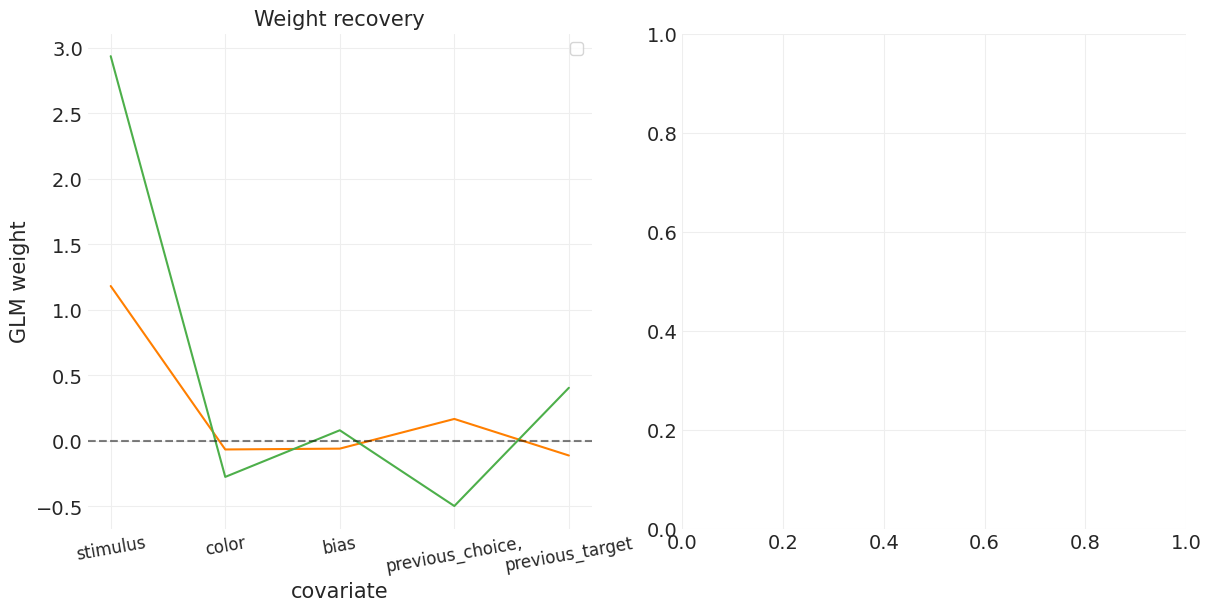

In [14]:
sub_idx = 0
num_states = 2
for sub_idx in range(14),
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    plot_weights(session_wise_fits['models'][sub_idx][num_states][0], _input_dim, axs[0])
    plot_weights(session_wise_fits['models'][sub_idx+14][num_states][0], _input_dim, axs[1])

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# OLD CODE

In [ ]:

x_hat = sim_x
y_hat = np.mean(sim_y_hat, axis=1)
y_std = np.std(sim_y_hat, axis=1)

y_err = stats.sem(sim_y_hat, axis=1)

plt.plot(x_hat, y_hat, label="Simulated", color="blue")
plt.fill_between(x_hat, y_hat - y_std, y_hat + y_std, color="green", alpha=1, label="Error Region")
# plt.fill_between(x_hat, y_hat - y_err, y_hat + y_err, color="green", alpha=1, label="Error Region")


pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = utils.get_psychometric_data(example_session)
plt.plot(pos_coh, pos_psych, 'o', label='data')

In [ ]:

x_hat = sim_x
y_hat = np.mean(sim_y_hat, axis=1)
y_std = np.std(sim_y_hat, axis=1)

y_err = stats.sem(sim_y_hat, axis=1)

plt.plot(x_hat, y_hat, label="Simulated", color="blue")
plt.fill_between(x_hat, y_hat - y_std, y_hat + y_std, color="green", alpha=1, label="Error Region")

In [ ]:
sim_data = pd.DataFrame()
sim_data['choice'] = np.array(choices_hat).flatten()
sim_data['signed_coherence'] = data['signed_coherence'][filter].values


pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = utils.get_psychometric_data(sim_data)

plt.plot(pos_x_hat, pos_y_hat, label='sim')

In [ ]:
plot_model_fit(glmhmm)

In [ ]:
# choices_hat[0][mask],
choices[0][mask].shape


x = choices[0][np.where(mask == 1)]
y = choices_hat[0][np.where(mask == 1)]

np.mean(x == y)

In [ ]:
loglikelihood_train, recovered_weights = fit_glm([this_inpt],
                                                             [this_y], M, C)
            weights_for_plotting = append_zeros(recovered_weights)
            plot_input_vectors(weights_for_plotting,
                               figure_directory,
                               title="GLM fit; Final LL = " +
                               str(loglikelihood_train),
                               save_title='init' + str(iter),
                               labels_for_plot=labels_for_plot)
            loglikelihood_train_vector.append(loglikelihood_train)